In [26]:
clear

## Caricamento Dati

La seguente funzione permette di caricare matrici sparse, provenienti dal sito [https://sparse.tamu.edu/](https://sparse.tamu.edu/), salvate su file nel formato matlab.<br>
Questa funzione riesce a gestire sia i vecchi formati (`< matlab v7.3`) che quelli nuovi.

In [27]:
function A = loadFunctionFromData(dataPath)
    disp(["🦍 Loading file: "  dataPath])
    load(dataPath)
    
%   se nel file è presente una `struct` allora vuol dire 
%   che sto utilizzando il nuovo formato e va convertito
%   per essere utilizzato da Octave
    if isstruct(Problem.A)
        n = length(Problem.A.jc)-1;
        ii = repelems(1:n, [1:n; diff(Problem.A.jc)]);
        A = sparse(Problem.A.ir+1, ii, Problem.A.data);
    else
        A = Problem.A;
    end
endfunction

In [28]:
% Esempio di come utilizzare la precedente funzione
% whos
% A = loadFunctionFromData('./data/cage15.mat');
% columns(A)
% rows(A)
% clear
% A = loadFunctionFromData('./data/vas_stokes_2M.mat');
% columns(A)
% rows(A)

La seguente funzione genera i dati iniziali per poter utilizzare GMRES.

In [29]:
function [A b x0] = generateData(dim, den, seed=69, randx0=false)
    rand("seed", seed);
    A = sprand(dim, dim, den);
    b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

In [30]:
function [A b x0] = generateData2(dim, n=-4, seed=69, randx0=false)
    rand("seed", seed);
    mu = 0;
    sigma = 1/(2*sqrt(dim));
    A = n * eye(dim) + normrnd(mu, sigma, dim);
    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

GMRES function

In [31]:
function [U]=gramschmidt(V)
    [n,k] = size(V);
    U = zeros(n,k);
    U(:,1) = V(:,1)/norm(V(:,1));
    
    for i = 2:k
        U(:,i)=V(:,i);
        
        for j=1:i-1
            U(:,i)=U(:,i)-(U(:,j)'*U(:,i)) * U(:,j);
        end
        
        U(:,i) = U(:,i)/norm(U(:,i));
    end
end

In [38]:
function [x res] = mygmres(A, b, x0, k, tol, reort)
    n = size(b)(1);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    
    H = zeros(k+2, k+1);
    Q = zeros(n, k+1);
    Q(:, 1) = r0/norm(r0, 2);
    
    en = zeros(k+2, 1);
    en(1) = 1;
        
    for j = 1:k
        v = A*Q(:, j);  
        %fare 2 volte
        for _ = 1:reort
            for i = 1:j
                %H(i,j) = Q(:,i)' * v;
                tmp = Q(:,i)' * v;
                v = v - tmp * Q(:, i);
                H(i,j) += tmp;
            end
        end
        % ortogonalizzazione ??
        %v = mgorth(v, Q); %% è quella bella
%         v = gramschmidt(v);

        H(j+1, j) = norm(v, 2);
        
        if (H(j+1, j) == 0)
            error("Divisione per 0 !!");
        end
        
        Q(:, j+1) = v / H(j+1, j);

%         % questo andrebbe rivisto
%         % il controllo deve essere != 0
%         if (abs(H(j+1, j)) > tol)
%             Q(:, j+1) = Q(:,j+1)/H(j+1,j);
%         end
        
        e1 = en(1:j+2);
        
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res(j) = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);

        if (res(j) < tol)
            x = Q(:, 1:j+1)*y +x0;
            disp('🚀 Raggiunta Tolleranza, stop');
            imagesc(H);
            return;
        end
    end
    x = Q(:, 1:j+1)*y +x0;
    disp('🐌 Raggiunto massimo numero di Iterazioni');
    imagesc(H);
endfunction

## Test 1 - Random Matrix

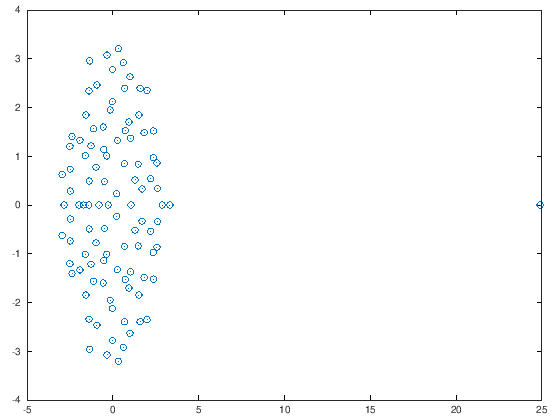

In [33]:
%[A, b, x0] = generateData(5000, .5
[A, b, x0] = generateData2(100);
%A = eye(30)*20;
%A = (ones(30)-0.999999999999) + eye(30)*2;

%eigval = eig(A);

%plot(eigval, 'o');


In [9]:
% A
% b
% x0
% L = gramschmidt(A)

🐌 Raggiunto massimo numero di Iterazioni


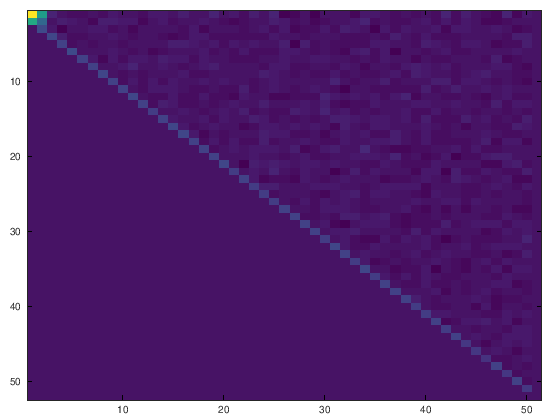

In [49]:
%[x, res] = mygmres(A, b, x0, 300, 1e-10);
[x, res] = mygmres(A, b, x0, 50, 1e-10, 4);

In [11]:
x
x_true = A\b
max(x_true-x)

x =

   8.6181e-04
   1.1908e-04
   1.0319e-03
   2.3300e-04
   4.9093e-04
   3.0090e-04
   8.9683e-04
   7.7862e-05
   8.5691e-04
   8.9979e-04
   4.9962e-04
   1.0332e-03
   9.4955e-04
   7.3048e-04
   7.3593e-04
   5.5990e-05
   7.8129e-04
   3.8820e-04
   3.7142e-04
   2.0697e-04
   7.3336e-05
   1.3214e-04
   5.5300e-05
   6.4094e-04
   8.9272e-04
   1.0419e-03
   9.6992e-04
   7.1329e-04
   3.6325e-04
   7.4498e-04
   1.2538e-04
   9.1751e-04
   3.0966e-04
   7.3867e-04
   7.4412e-04
   5.3451e-04
   1.2772e-04
   8.5747e-04
   6.7402e-04
   4.6681e-04
   2.9558e-04
   8.6508e-04
   6.4083e-04
   8.1035e-04
   8.0392e-04
   5.3849e-04
   5.5663e-04
   6.3698e-04
   6.8631e-04
   7.0317e-04
   1.5624e-04
   8.6428e-04
   8.1646e-04
   6.6808e-04
   6.8093e-04
   7.0475e-04
   5.8782e-04
   3.5929e-04
   2.1112e-04
   4.8614e-04
   2.5284e-04
   4.0595e-04
   7.7471e-04
   2.2664e-04
   3.6934e-04
   6.6344e-04
   4.1535e-04
   4.8579e-04
   8.8201e-04
   6.4070e-04
   9.2347e-04
 

x_true =

   9.7338e-01
  -6.3423e-01
   2.9081e-01
   1.3121e-01
  -3.2428e-01
  -8.8272e-01
   3.0504e-01
   8.3041e-02
   9.2889e-01
  -4.3536e-02
  -1.5236e+00
  -9.2119e-01
  -1.3343e+00
  -6.6113e-01
   7.2082e-01
   8.2689e-01
   1.5389e+00
  -2.4673e-01
   5.6685e-01
  -9.3071e-01
   1.5257e+00
   4.4497e-01
   2.6459e-01
   9.0458e-01
   1.7446e+00
   2.7391e-02
  -5.8333e-01
  -1.7331e-01
  -2.9001e-01
  -5.5906e-01
   5.1141e-01
   1.1011e+00
  -7.0349e-01
  -5.3558e-01
   1.8403e+00
  -5.4698e-02
  -9.4199e-01
   7.1416e-01
  -2.5589e-01
   1.7089e+00
   1.2341e+00
  -1.8363e+00
  -4.2052e-01
  -6.6010e-01
   4.4486e-01
  -9.1136e-01
   1.0914e+00
  -6.0847e-01
  -7.0315e-01
   3.2244e-02
   1.5476e+00
   2.8980e-01
  -1.9941e+00
   1.6130e+00
   5.0374e-01
   8.5595e-01
  -8.2135e-01
   1.3107e+00
   2.8577e-02
  -2.0649e-01
  -3.7189e-01
   1.7312e+00
  -7.7763e-01
  -9.3419e-01
   1.3906e-01
  -9.9795e-02
   1.8932e+00
  -5.4829e-01
  -8.6771e-01
  -1.6971e+00
   6.4068e

ans =  3.3707


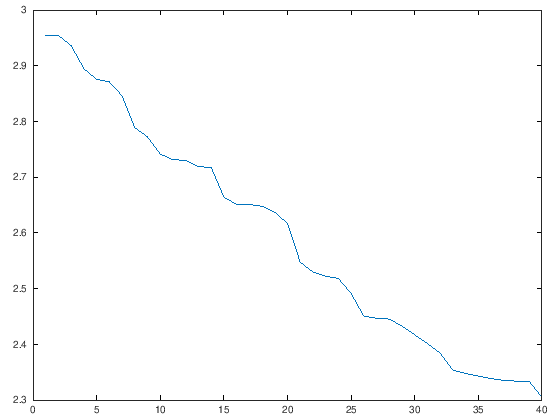

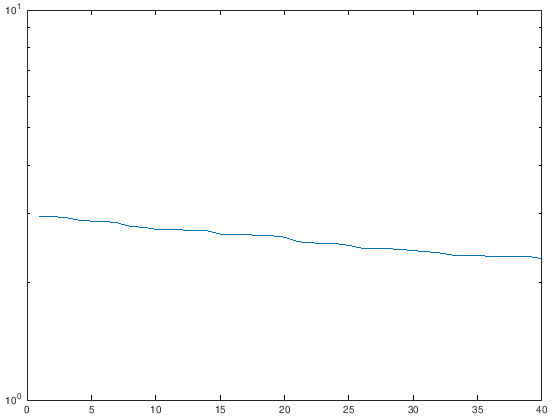

In [44]:
%%ort1
figure();
plot(res);
figure();
semilogy(res);

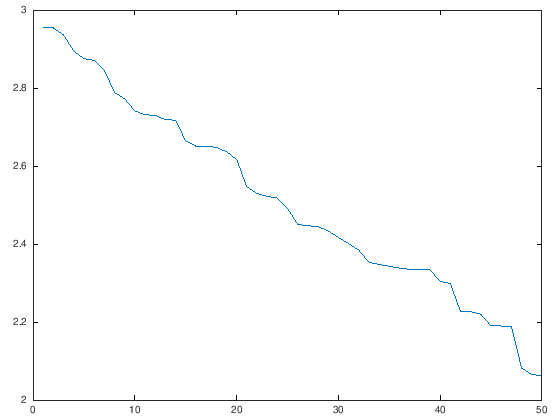

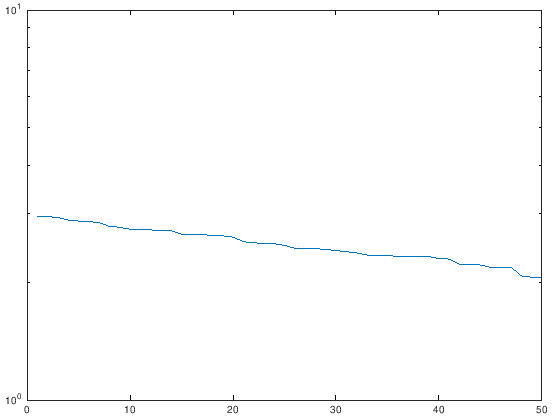

In [50]:
%%ort2
figure();
plot(res);
figure();
semilogy(res);

## Test 2 - randnorm()

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.088062
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.46890
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
approx_error =  294.49
🍌 n = 2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.60557
🍌 n = 4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.11296


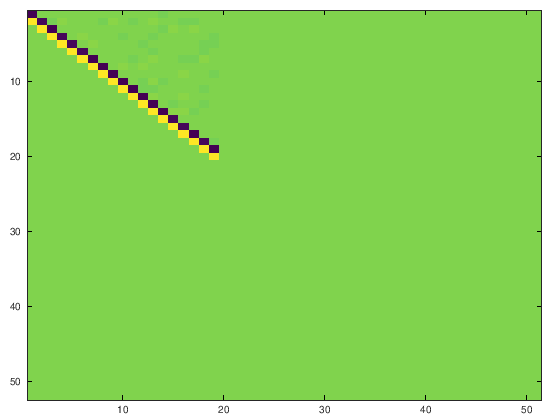

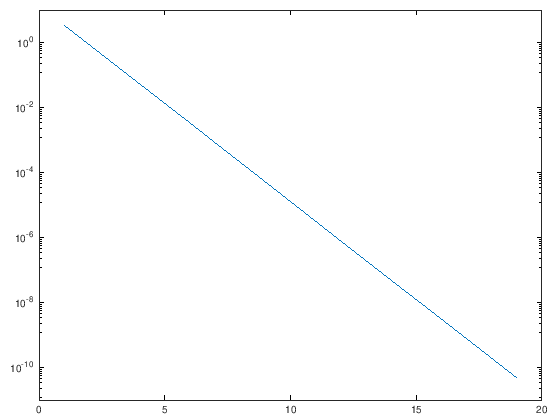

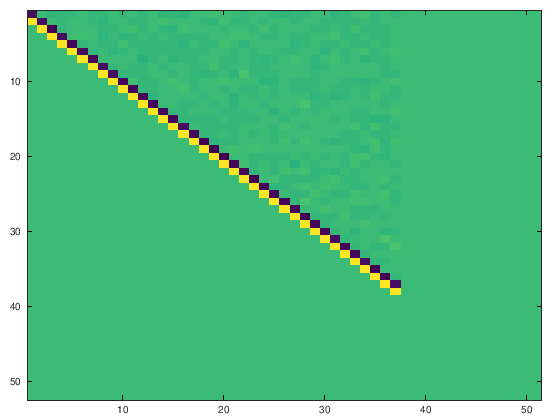

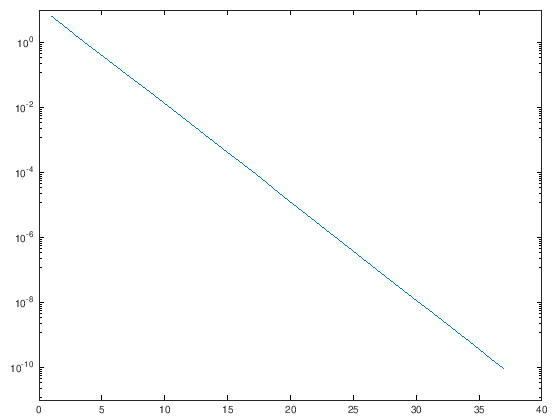

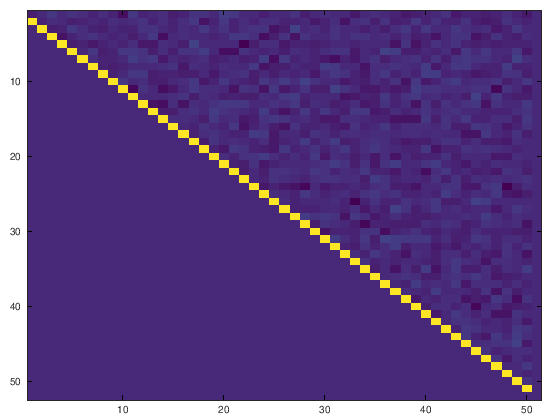

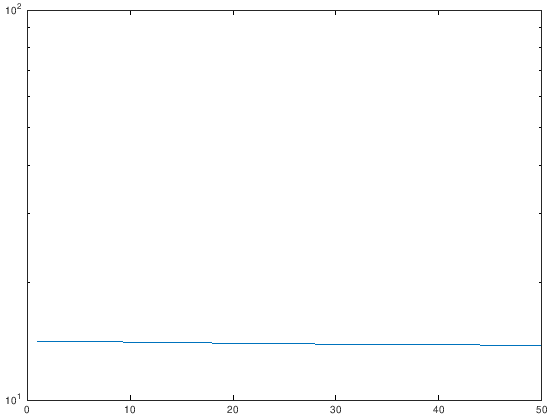

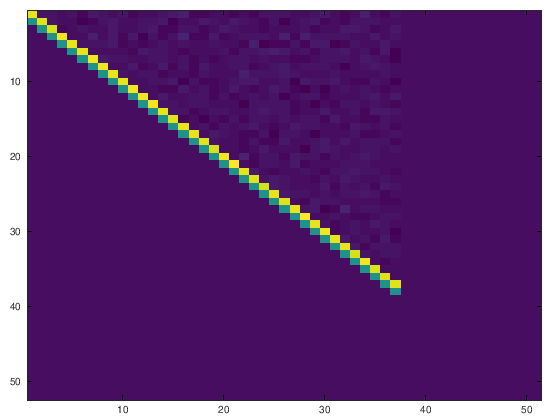

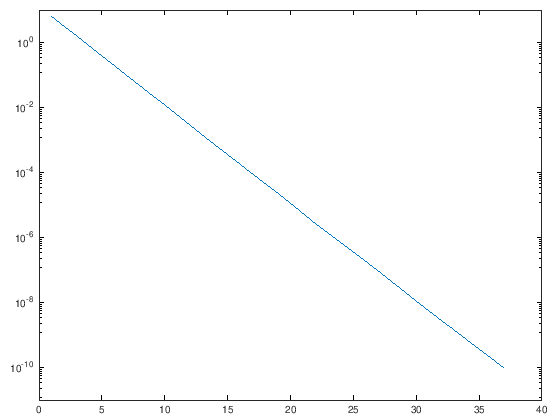

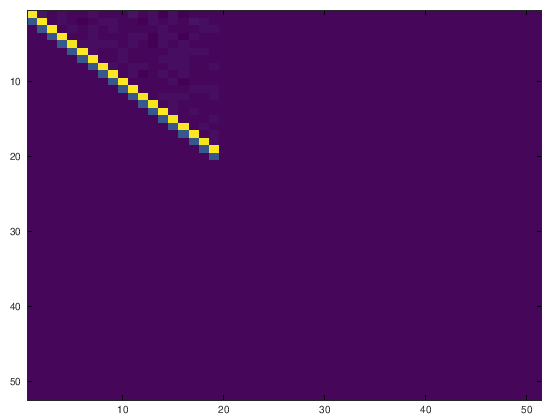

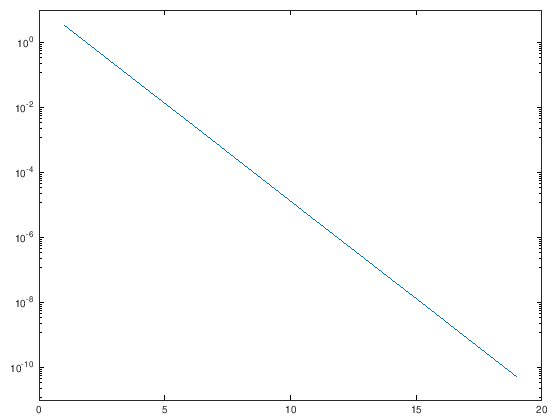

In [13]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    
    [A, b, x0] = generateData2(200, n=n);
    [x, res] = mygmres(A, b, x0, 50, 1e-10);
    
    x_true = A\b;
    approx_error = max(x_true-x)
    
    figure();
    title(["GMRES with n = " mat2str(n)]);
    semilogy(res);
end

## GMRES(m)

In [14]:
function [x res] = myrgmres(A, b, x0, k, tol, m)
    restartCount = 0;
    res = [];
    n = size(b)(1);
    en = zeros(k+2, 1);
    en(1) = 1;
    Q = zeros(n, k+1);

    while (restartCount < m)
        H = zeros(k+2, k+1);

        r0 = b - A * x0;
        beta = norm(r0, 2);
        Q(:, 1) = r0/norm(r0, 2);

        for j = 1:k
            v = A*Q(:, j);   
            for i = 1:j
                H(i,j) = Q(:,i)' * v;
                v = v - H(i, j) * Q(:, i);
            end
            
%             v =  gramschmidt(v);
            v = mgorth(v, Q);  % equivalente a quella sopra
            
            H(j+1, j) = norm(v, 2);
            
            if (H(j+1, j) == 0)
                error("Divisione per 0 !!");
            end
        
            Q(:, j+1) = v / H(j+1, j);
            
%             if (abs(H(j+1, j)) > tol)
%                 Q(:, j+1) = v / H(j+1, j);
%             end

            e1 = en(1:j+2);

            y =(H(1:j+2,1:j+1))\(beta *e1);
            res = [res norm(H(1:j+2,1:j+1)*y - beta*e1, 2)];

            if (res(end) < tol)
                x = Q(:, 1:j+1)*y +x0;
                disp('🚀 Raggiunta Tolleranza, stop');
                imagesc(H(1:j, 1:j));
                return;
            end
        end
        
        x = Q(:, 1:j+1)*y +x0;
        x0 = x;
        restartCount = restartCount + 1;
        
        disp('🐌 Raggiunto massimo numero di Iterazioni');
        disp('🗿 Restarting ...');
%         imagesc(H);
    end
    
    disp('❌ Raggiunto massimo numero di Restart');
    imagesc(H);
endfunction

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


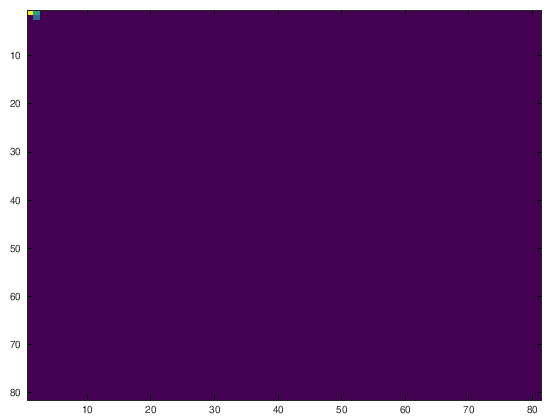

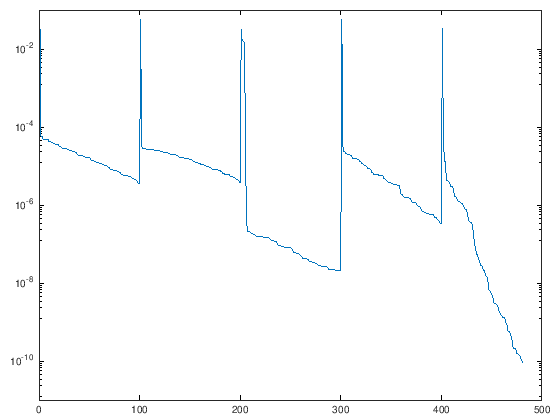

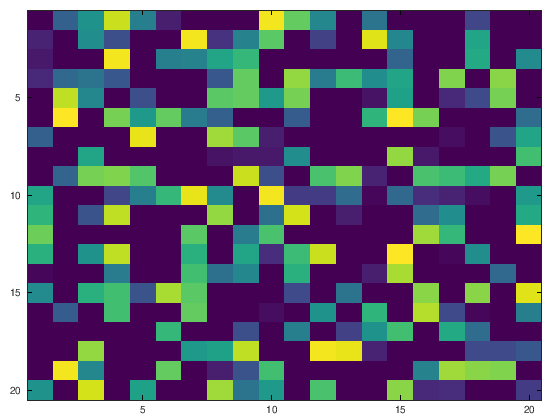

In [15]:
[A, b, x0] = generateData(9000, .5);

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🚀 Raggiunta Tolleranza, stop


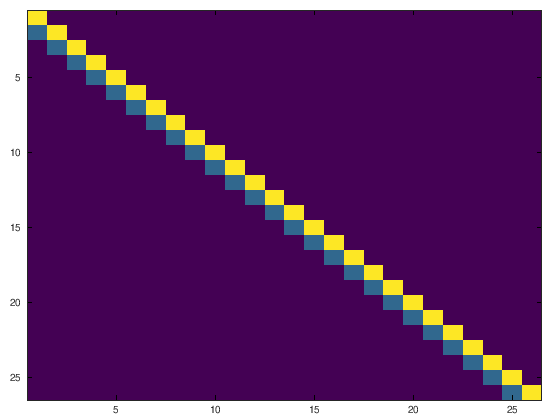

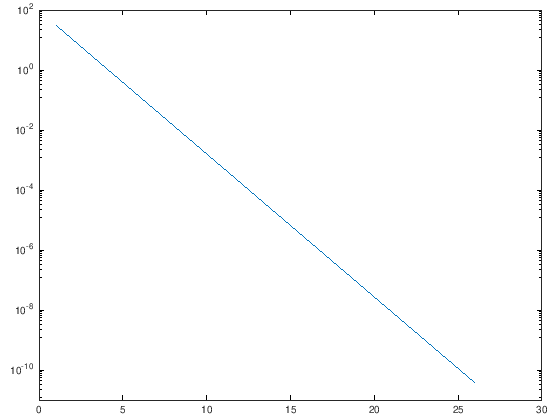

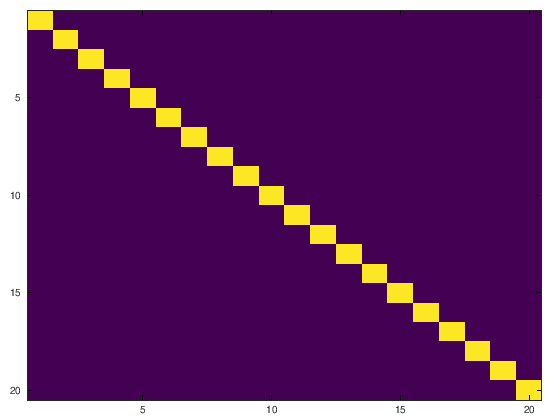

In [16]:
[A, b, x0] = generateData2(10000, 3);

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


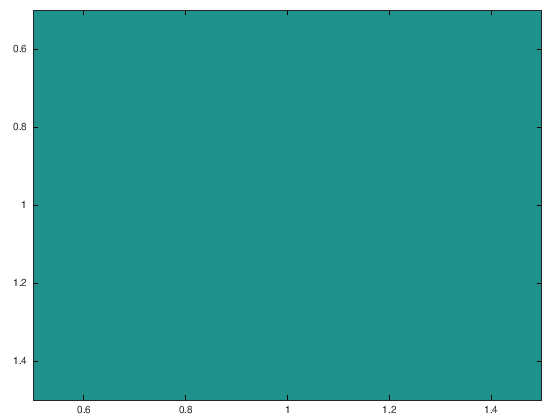

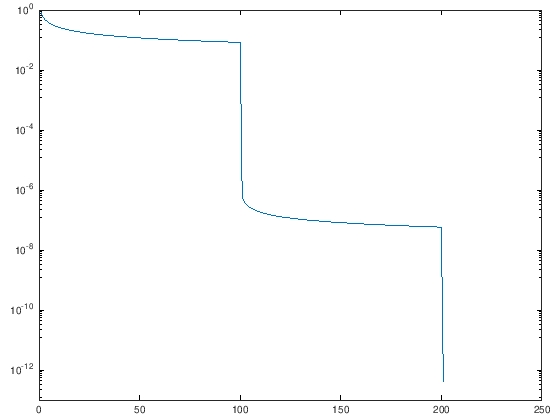

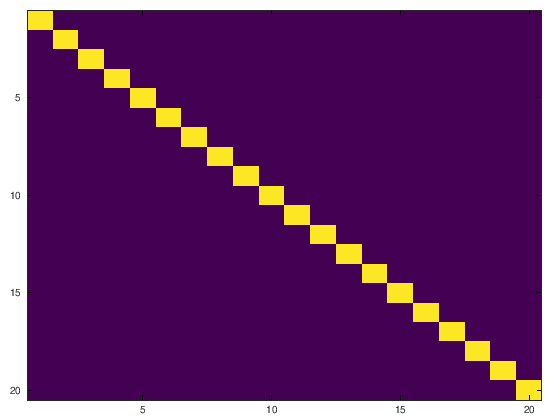

In [17]:
A = eye(10000)*120;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🚀 Raggiunta Tolleranza, stop


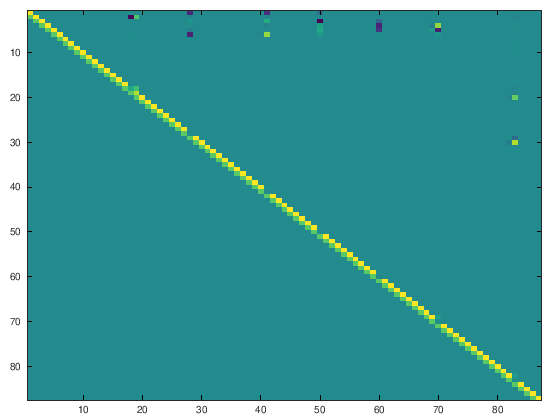

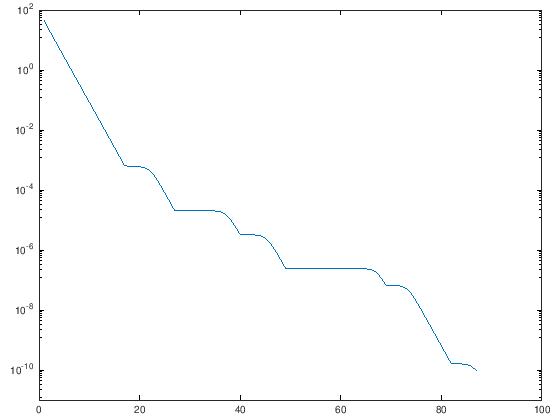

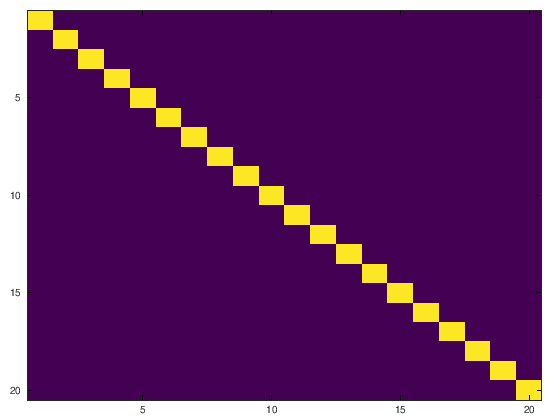

In [18]:
A = (ones(10000)-0.999999999999) + eye(10000)*2;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


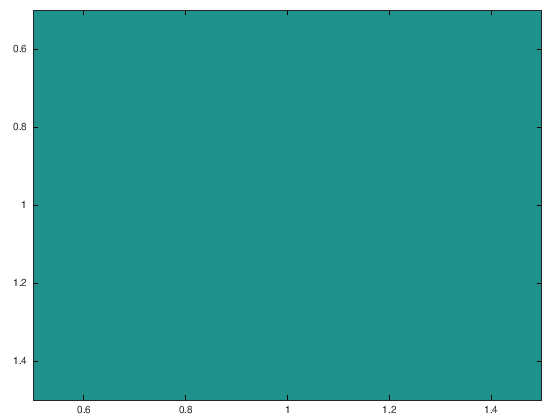

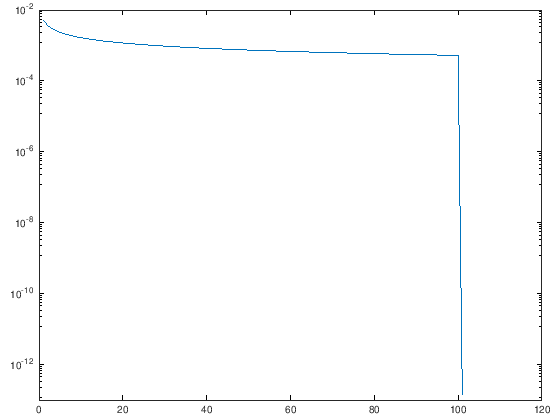

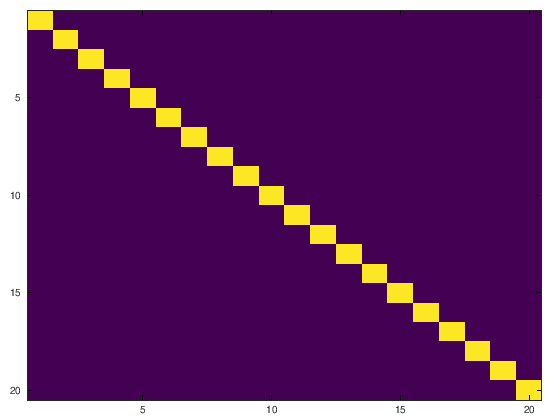

In [19]:
A = (ones(10000)+.9) + eye(10000)*3;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:20, 1:20));
% A(1:10, 1:10)

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.10354
normm =  1.8805
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.41524
normm =  4.1312
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo nume

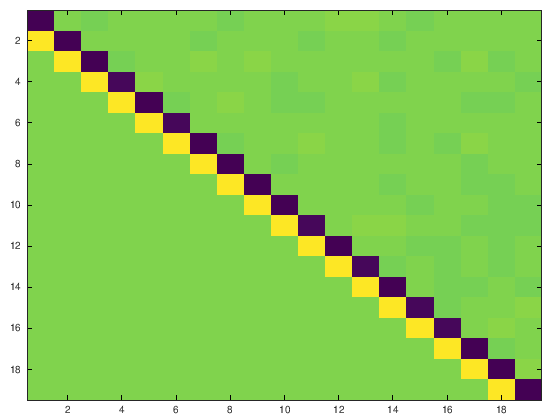

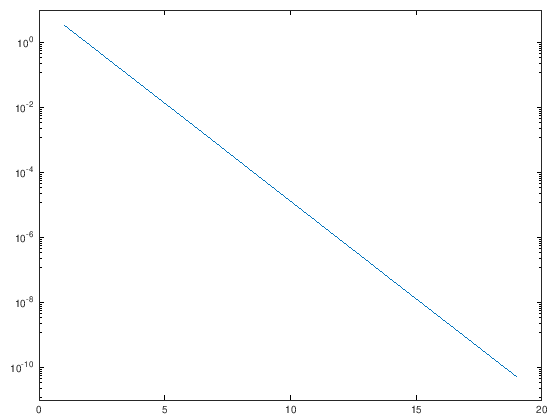

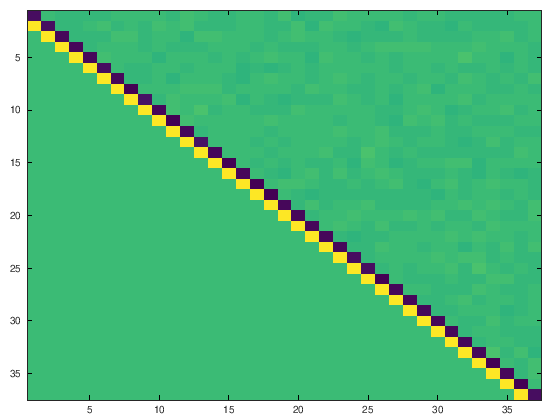

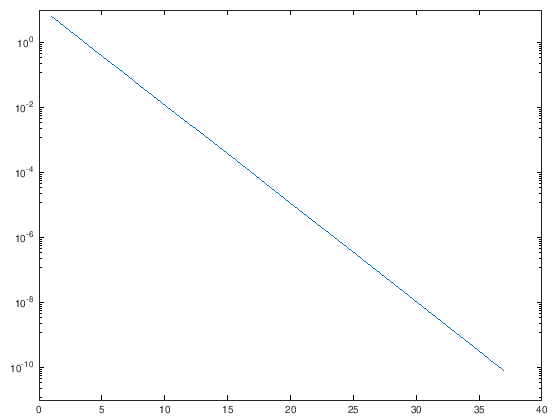

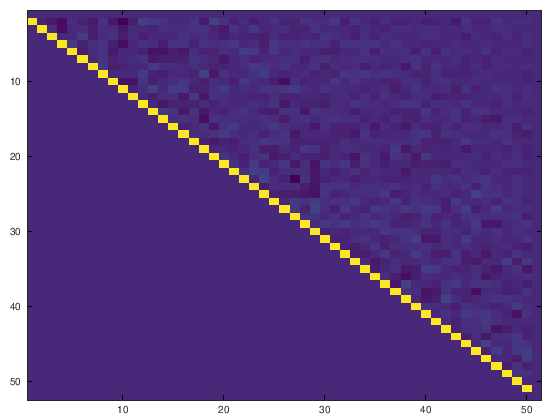

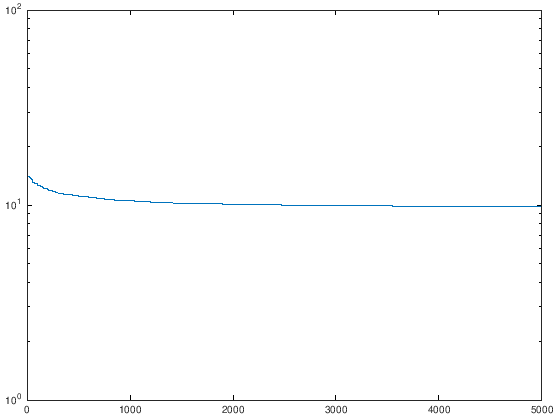

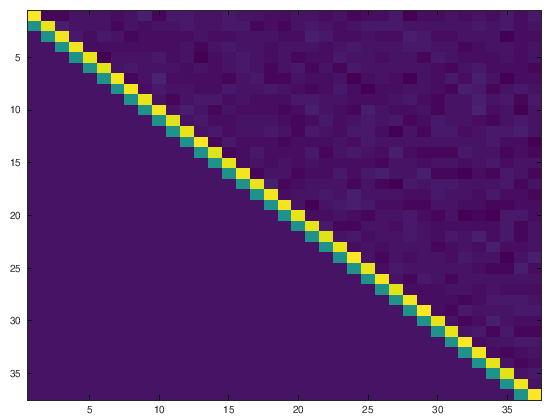

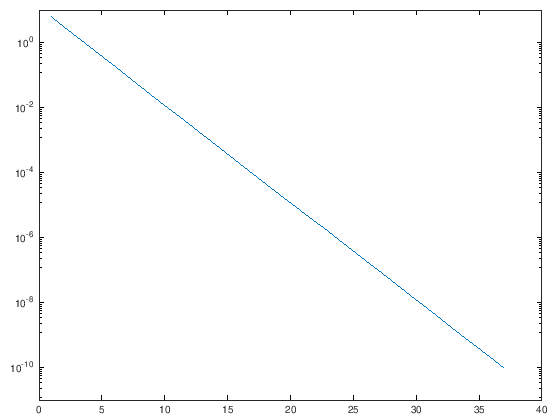

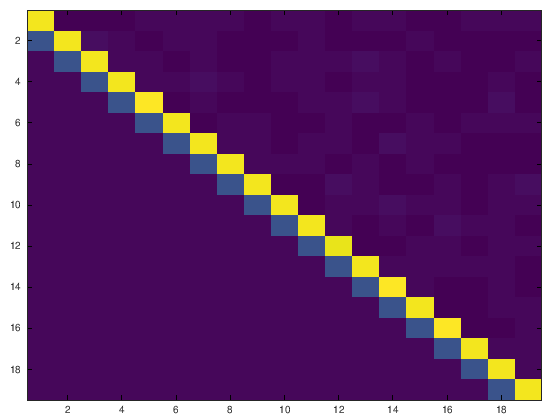

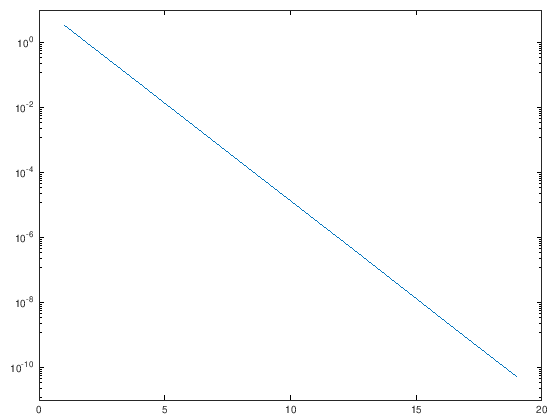

In [20]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    [A, b, x0] = generateData2(200, n=n);
    [x, res] = myrgmres(A, b, x0, 50, 1e-10, 100);
    
    % x;
    x_true = A\b;
    approx_error = max(x_true-x)
    normm = norm(A*x - b)
    
    figure();
    title(["GMRES with n = " mat2str(n)]);
    semilogy(res);
end

## Other Stuff 📦

In [ ]:
%% questo non sembra funzionare
function [B] = myGramschmidt(A)
    B = A;

    for k = 1:size(A, 1)
        for j = 1:k-1
            B(k, :) = B(k, :) - proj(B(j, :), A(k, :));
        end
    end
end

function p = proj(u, v)
% https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process#The_Gram.E2.80.93Schmidt_process
    p = dot(v, u) / dot(u, u) * u;
end

In [ ]:
function [Q, H, breakdown] = ANROLDI(A, b,Qold, Hold, n, tol)
    Hold
    if any(Hold) || isempty(Hold)
        H = [0 0]'
    else
%         H = [Hold 0;
%              0 0];
        H = [Hold zeros(size(Hold, 1), 1);
            zeros(1, size(Hold, 2) + 1)];
    end
    
    Q = [Qold  zeros(size(Qold, 1), 1)];
%     Qold
    w = A * Q(:, n);
    
    for i = max(1, n-1):n
        H(i, n) = Q(:, i)' * w;
        w = w - H(i, n) * Q(:, i);
    end
    w
    H(n+1, n) = norm(w);
    breakdown = norm(H(n+1, n)) < tol;
    Q(:, n+1) = w/norm(w);
endfunction

In [ ]:
function [x res] = altrogmres(A, b, x0, k, tol)
    Q = ones(size(b, 1), size(b, 1));
%     Q = zeros(;
    H = [];
    r0 = b - A * x0;
    beta = norm(r0, 2);
    e1 = zeros(size(b, 1), 1);
    e1(1) = 1;
    res = 0;
    for j=1:k
        [Q, H, breakdown] = ANROLDI(A, b, Q, H, j, tol);
        
        if (abs(H(j+1, j)) > tol)
            Q(:, j+1) = Q(:,j+1)/H(j+1,j);
        end
        
        e1 = zeros(j+1, 1);
        e1(1) = 1;

%         y =(H(1:j+2,1:j+1))\(beta *e1);
        y =H\(beta *e1(1:j+1));
%         res = norm(H(1:j+1,1:j)*y - beta*e1, 2);
        x = Q(:, 1:j) * y
%         disp(H(j+1,j))
%         disp(e1(1:j+1)*y)
%         res = (H(j+1,j) * abs(e1*y))/beta;
%         if (res < tol)
%             disp('Raggiunta toll');
%             x = Q(:, 1:j+1)*y +x0;
%             return;
%         end
    end
endfunction


In [ ]:
[x res] = altrogmres(A, b, x0, 10, 1e-10);

In [ ]:
function [x res] = cgmres(A, b, x0, k, tol)
    n = size(b)(1);
    Q = zeros(n, k+1);
    H = zeros(k+1, k);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    Q(:, 1) = r0/norm(r0, 2);
%     e1 = zeros(n, 1);
%     e1(1) = 1;
%     e1 = e1';
    for j = 1:k  %% TODO: ricontrollare
        imagesc(H);
        disp(j);
        
        Q(:,j+1) = A * Q(:, j);
        
        for i = 1:j
            H(i,j) = Q(:,i)' * Q(:, j+1);
            Q(:, j+1) = Q(:, j+1) - H(i,j) * Q(:,i);
        end
        
        H(j+1, j) = norm(Q(:, j+1), 2);
        
        if (abs(H(j+1, j)) > tol)
            Q(:, j+1) = Q(:,j+1)/H(j+1,j);
        end
        
        e1 = zeros(j+2, 1);
        e1(1) = 1;
%         e1 = e1';
        %%TODO: ricontrollare
%         y=0
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);
        
        if (res < tol)
            disp('Raggiunta toll');
            x = Q(:, 1:j+1)*y +x0;
            return;
        end
    end
    x = Q(:, 1:j+1)*y +x0;
%     return;   % potrebbe essere superfluo
endfunction